# ビン化＋欠損マスクで3系統スコア（横ずれ／上下／周波数+スパイク）

前提データ：1サンプル = `[cycle_id, deg, s1, label]`（npzの list 形式）

狙い：
- 横ずれ（位相ずれ）：テンプレートとの円環相互相関 → シフト量をスコア化
- 上下シフト：整列後にテンプレートとの差の平均（DC）をスコア化
- 周波数成分変化・スパイク：整列後残差から FFT 帯域パワーと外れ値指標を計算して統合

この版は CWT/Conv2D を使いません。まず分解スコアが期待通りに動くか確認するための基礎実装です。

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# 0) 設定（ここだけ最初に調整）
# ============================================================
NPZ_PATH = "dataset_irregular.npz"  # list保存npz
L_GRID   = 256   # 0〜360度を何分割するか（ビン数）
SEED     = 0

# --- 周波数（FFT）で見る帯域（高調波次数 k）---
# 例：生成側で k=6〜9 を足しているなら、そこを中心に見ると強い
K_BAND_LO = 2
K_BAND_HI = 80

# --- 閾値（正常calibの分位点）---
Q_PHASE   = 0.995
Q_OFFSET  = 0.995
Q_FREQSPK = 0.995

# 正常データの分割（テンプレ作成・統計推定用 / 閾値決定用）
CAL_RATIO = 0.20  # 正常のうち閾値用に回す割合

np.random.seed(SEED)

In [4]:
# ============================================================
# 1) 読み込み（1サンプル=[cycle_id, deg, s1, label]）
# ============================================================
d = np.load(NPZ_PATH, allow_pickle=True)
train_list = d["train_list"].tolist()
test_list  = d["test_list"].tolist()

def group_by_cycle(sample_list):
    # list[list] を cycle_id ごとにまとめる
    # 戻り値: cycles[cid] = (deg_array, y_array, label_int)
    arr = np.asarray(sample_list, dtype=object)
    cid = arr[:,0].astype(int)
    deg = arr[:,1].astype(float)
    y   = arr[:,2].astype(float)
    lab = arr[:,3].astype(int)

    # cycle→deg の順でソート（後段が安定）
    order = np.lexsort((deg, cid))
    cid, deg, y, lab = cid[order], deg[order], y[order], lab[order]

    cycles = {}
    start = 0
    while start < len(cid):
        c = int(cid[start])
        end = start
        while end < len(cid) and int(cid[end]) == c:
            end += 1
        cycles[c] = (deg[start:end], y[start:end], int(lab[start]))
        start = end
    return cycles

train_cycles = group_by_cycle(train_list)
test_cycles  = group_by_cycle(test_list)

def label_counts(cycles_dict):
    labs = np.array([lab for (_,_,lab) in cycles_dict.values()], dtype=int)
    u,c = np.unique(labs, return_counts=True)
    return {int(k): int(v) for k,v in zip(u,c)}

print("[cycle counts]")
print("train cycles:", len(train_cycles), "label counts:", label_counts(train_cycles))
print("test  cycles:", len(test_cycles),  "label counts:", label_counts(test_cycles))

[cycle counts]
train cycles: 700 label counts: {0: 700}
test  cycles: 1020 label counts: {0: 720, 1: 60, 2: 60, 3: 60, 4: 60, 5: 60}


In [5]:
# ============================================================
# 2) ビン化（0〜360度 → L_GRIDビン） + 欠損マスク
# ============================================================
deg_step = 360.0 / L_GRID

def bin_cycle(deg, y, L=L_GRID):
    # 不等間隔( deg, y ) を Lビンの等間隔ベクトルに落とす
    # - 複数点が同じビンに入る場合は平均
    # - 入らないビンは欠損として mask=0
    x_sum = np.zeros(L, dtype=float)
    cnt   = np.zeros(L, dtype=int)

    deg_mod = np.mod(deg, 360.0)
    idx = np.floor(deg_mod / (360.0 / L)).astype(int)
    idx = np.clip(idx, 0, L-1)

    for i, v in zip(idx, y):
        x_sum[i] += float(v)
        cnt[i]   += 1

    msk = (cnt > 0).astype(float)
    x   = np.zeros(L, dtype=float)
    ok = cnt > 0
    x[ok] = x_sum[ok] / cnt[ok]
    return x.astype(np.float32), msk.astype(np.float32), cnt

def build_binned_matrix(cycles_dict, L=L_GRID):
    # cycles_dict から X:(N,L), M:(N,L), y:(N,), cid:(N,) を作る
    cids = sorted(cycles_dict.keys())
    X_list, M_list, y_list = [], [], []
    for cid in cids:
        deg, sig, lab = cycles_dict[cid]
        x, m, _ = bin_cycle(deg, sig, L)
        X_list.append(x)
        M_list.append(m)
        y_list.append(lab)
    X = np.stack(X_list, axis=0)
    M = np.stack(M_list, axis=0)
    y = np.array(y_list, dtype=int)
    cid = np.array(cids, dtype=int)
    return X, M, y, cid

Xtr, Mtr, ytr, cidtr = build_binned_matrix(train_cycles, L_GRID)
Xte, Mte, yte, cidte = build_binned_matrix(test_cycles,  L_GRID)

print("[binned shapes]")
print("Xtr:", Xtr.shape, "Mtr:", Mtr.shape)
print("Xte:", Xte.shape, "Mte:", Mte.shape)
print("deg_step:", deg_step, "[deg/bin]")

[binned shapes]
Xtr: (700, 256) Mtr: (700, 256)
Xte: (1020, 256) Mte: (1020, 256)
deg_step: 1.40625 [deg/bin]


In [6]:
# ============================================================
# 3) 正常データを split（テンプレ/統計用 vs 閾値calib用）
# ============================================================
idx0 = np.where(ytr == 0)[0]
if len(idx0) == 0:
    raise ValueError("学習データに正常(label=0)がありません。")

rng = np.random.default_rng(SEED)
perm = rng.permutation(idx0)

n_cal = max(1, int(round(CAL_RATIO * len(idx0))))
idx_cal = perm[:n_cal]   # 閾値決め専用（fitには使わない）
idx_fit = perm[n_cal:]   # テンプレ・統計（正常の分布）を作る

print("[normal split]")
print("normal total:", len(idx0))
print("fit  (template/stats):", len(idx_fit))
print("calib(threshold)     :", len(idx_cal))

[normal split]
normal total: 700
fit  (template/stats): 560
calib(threshold)     : 140


In [7]:
# ============================================================
# 4) 正常テンプレート（基準波形）を作る（欠損を無視した平均）
# ============================================================
def masked_mean(X, M, eps=1e-8):
    num = (X * M).sum(axis=0)
    den = M.sum(axis=0) + eps
    return (num / den).astype(np.float32)

template = masked_mean(Xtr[idx_fit], Mtr[idx_fit])

# テンプレートが欠損ビン（den=0）になる可能性があるので埋める（安全策）
tmpl_mean = float(np.mean(template))
missing_bins = (Mtr[idx_fit].sum(axis=0) == 0)
template[missing_bins] = tmpl_mean

print("template built. missing_bins:", int(missing_bins.sum()))

template built. missing_bins: 0


In [8]:
# ============================================================
# 5) 横ずれ（位相ずれ）スコア：円環相互相関でシフト量を推定
# ============================================================
def circular_shift_from_template(x, m, template):
    # 欠損があると相関が壊れやすいので、欠損ビンは template で埋めてから相関を取る
    L = len(template)
    x_f = np.where(m > 0.5, x, template).astype(np.float32)

    # 上下シフトの影響を減らすため平均を引く
    a = x_f - float(np.mean(x_f))
    b = template - float(np.mean(template))

    # 円環相互相関：corr[lag] = sum_t a[t] * b[t+lag]
    corr = np.fft.ifft(np.fft.fft(a) * np.conj(np.fft.fft(b))).real

    k = int(np.argmax(corr))  # 0..L-1
    k_signed = (k - L) if (k > L//2) else k

    # 定義：x を shift_bins だけ roll すると template と揃う
    shift_bins = -k_signed
    shift_deg = shift_bins * (360.0 / L)
    return int(shift_bins), float(shift_deg), float(corr[k])

def apply_circular_shift(x, m, shift_bins):
    return np.roll(x, shift_bins).astype(np.float32), np.roll(m, shift_bins).astype(np.float32)

# quick check
i0 = idx_fit[0]
sb, sd, cp = circular_shift_from_template(Xtr[i0], Mtr[i0], template)
print("example shift_bins:", sb, "shift_deg:", sd, "corr_peak:", cp)

example shift_bins: 0 shift_deg: 0.0 corr_peak: 145.22562160780623


In [9]:
# ============================================================
# 6) 3系統スコア
#    (A) 横ずれ: |shift_deg|
#    (B) 上下:   |mean(residual)|   （整列後）
#    (C) 周波数+スパイク: 整列後残差から作る
# ============================================================
def scores_for_one_cycle(x, m, template):
    # --- (A) 横ずれ ---
    shift_bins, shift_deg, _ = circular_shift_from_template(x, m, template)
    score_phase = abs(shift_deg)

    # 欠損埋め→整列（横ずれの影響を除去した状態を作る）
    x_f = np.where(m > 0.5, x, template).astype(np.float32)
    x_al, m_al = apply_circular_shift(x_f, m, shift_bins)

    # 残差
    r = (x_al - template).astype(np.float32)

    # 欠損ビンは評価に入れない（maskで重み）
    w = (m_al > 0.5).astype(np.float32)
    denom = float(w.sum()) + 1e-8

    # --- (B) 上下（DC） ---
    offset = float((r * w).sum() / denom)
    score_offset = abs(offset)

    # --- (C) 周波数+スパイク ---
    # 上下を除いた残差で計算（上下と分離）
    r0 = (r - offset).astype(np.float32)

    # (C-1) 周波数：FFTバンドパワー比（スケールに強い）
    r_use = (r0 * w).astype(np.float32)  # 欠損は0に
    F = np.fft.rfft(r_use)
    P = (np.abs(F) ** 2).astype(np.float64)
    total = float(P[1:].sum()) + 1e-12  # DC除外

    k_lo = int(max(1, K_BAND_LO))
    k_hi = int(min(len(P)-1, K_BAND_HI))
    band = float(P[k_lo:k_hi+1].sum())
    score_freq = band / total

    # (C-2) スパイク：残差|r0|の上位分位点（maxより安定）
    r_abs = np.abs(r0[w > 0.5])
    score_spike = float(np.quantile(r_abs, 0.995)) if r_abs.size else 0.0

    return score_phase, score_offset, score_freq, score_spike

def compute_scores_matrix(X, M, template):
    N = X.shape[0]
    s_phase  = np.zeros(N, float)
    s_offset = np.zeros(N, float)
    s_freq   = np.zeros(N, float)
    s_spike  = np.zeros(N, float)
    for i in range(N):
        a,b,c,d = scores_for_one_cycle(X[i], M[i], template)
        s_phase[i]  = a
        s_offset[i] = b
        s_freq[i]   = c
        s_spike[i]  = d
    return s_phase, s_offset, s_freq, s_spike

# fit正常（統計）
sP_fit, sO_fit, sF_fit, sS_fit = compute_scores_matrix(Xtr[idx_fit], Mtr[idx_fit], template)
# calib正常（閾値）
sP_cal, sO_cal, sF_cal, sS_cal = compute_scores_matrix(Xtr[idx_cal], Mtr[idx_cal], template)
# test全体
sP_te,  sO_te,  sF_te,  sS_te  = compute_scores_matrix(Xte, Mte, template)

print("[score quantiles on normal-fit]")
print("phase deg  :", np.quantile(sP_fit, [0.5,0.9,0.99]))
print("offset abs :", np.quantile(sO_fit, [0.5,0.9,0.99]))
print("freq ratio :", np.quantile(sF_fit, [0.5,0.9,0.99]))
print("spike q995 :", np.quantile(sS_fit, [0.5,0.9,0.99]))

[score quantiles on normal-fit]
phase deg  : [0. 0. 0.]
offset abs : [0.00355087 0.00823291 0.01299897]
freq ratio : [0.62312453 0.67655325 0.71117761]
spike q995 : [0.2137554  0.23928097 0.26451381]


In [10]:
# ============================================================
# 7) 正規化（ロバスト）→ 統合スコア → 閾値 → 判定
# ============================================================
def robust_z(x, ref):
    # ref（正常fit）の中央値とMADでロバスト正規化
    med = float(np.median(ref))
    mad = float(np.median(np.abs(ref - med))) * 1.4826 + 1e-12
    return (x - med) / mad

# 周波数/スパイクは z 化して max を取って1本にする
zF_cal = robust_z(sF_cal, sF_fit)
zS_cal = robust_z(sS_cal, sS_fit)
zFS_cal = np.maximum(zF_cal, zS_cal)

zF_te = robust_z(sF_te, sF_fit)
zS_te = robust_z(sS_te, sS_fit)
zFS_te = np.maximum(zF_te, zS_te)

thr_phase   = float(np.quantile(sP_cal, Q_PHASE))
thr_offset  = float(np.quantile(sO_cal, Q_OFFSET))
thr_freqspk = float(np.quantile(zFS_cal, Q_FREQSPK))

print("[thresholds]")
print("thr_phase_deg :", thr_phase)
print("thr_offset_abs:", thr_offset)
print("thr_freqspk_z :", thr_freqspk)

# OR統合：どれかが超えたら異常
pred_te = (
    (sP_te  > thr_phase) |
    (sO_te  > thr_offset) |
    (zFS_te > thr_freqspk)
).astype(int)

y_te_bin = (yte != 0).astype(int)
acc = float(np.mean(pred_te == y_te_bin))
tp = int(np.sum((pred_te==1) & (y_te_bin==1)))
tn = int(np.sum((pred_te==0) & (y_te_bin==0)))
fp = int(np.sum((pred_te==1) & (y_te_bin==0)))
fn = int(np.sum((pred_te==0) & (y_te_bin==1)))
tpr = tp / max(1, tp+fn)
fpr = fp / max(1, fp+tn)

print("test acc (normal vs others):", acc)
print({"tp":tp,"tn":tn,"fp":fp,"fn":fn,"tpr":tpr,"fpr":fpr})

[thresholds]
thr_phase_deg : 0.4289062500000096
thr_offset_abs: 0.013951384394454383
thr_freqspk_z : 2.49236128906504
test acc (normal vs others): 0.9627450980392157
{'tp': 285, 'tn': 697, 'fp': 23, 'fn': 15, 'tpr': 0.95, 'fpr': 0.03194444444444444}


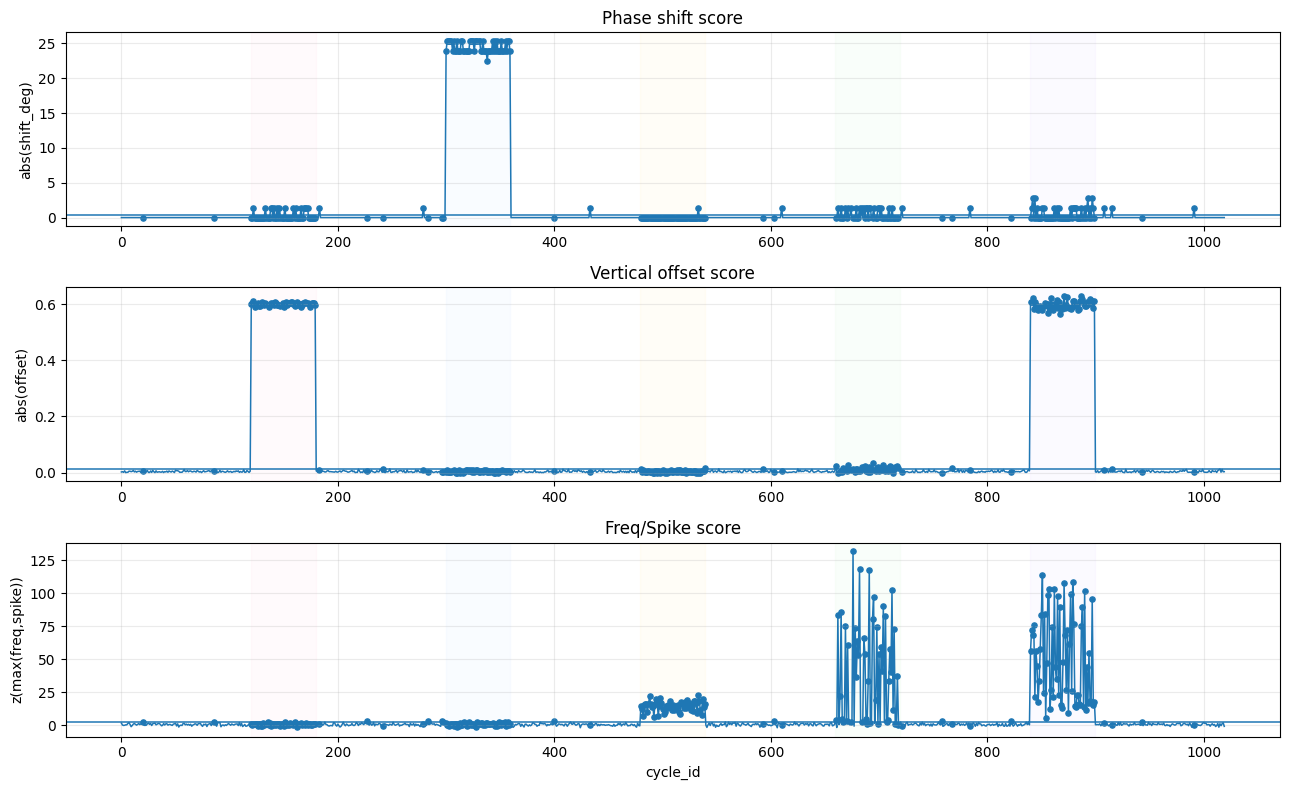

In [11]:
# ============================================================
# 8) 可視化：3系統スコアと判定（背景=真ラベル）
# ============================================================
label_name  = {0:"正常",1:"上下",2:"横ずれ",3:"周波数",4:"スパイク",5:"mix"}
label_color = {0:"#ffffff",1:"#ffd6e7",2:"#d0ebff",3:"#fff3bf",4:"#d3f9d8",5:"#e5dbff"}

order = np.argsort(cidte)
cid_s  = cidte[order]
y_s    = yte[order]
pred_s = pred_te[order]

sP_s  = sP_te[order]
sO_s  = sO_te[order]
zFS_s = zFS_te[order]

def plot_score(ax, x, thr, title, ylabel):
    ax.plot(cid_s, x, linewidth=1.1)
    ax.axhline(thr, linewidth=1.1)

    # 背景：真ラベルで区間塗り
    start = 0
    while start < len(cid_s):
        lab = int(y_s[start])
        end = start
        while end < len(cid_s) and int(y_s[end]) == lab:
            end += 1
        ax.axvspan(cid_s[start]-0.5, cid_s[end-1]+0.5, alpha=0.12, color=label_color.get(lab, "#ffffff"))
        start = end

    # 予測異常を点でマーク
    idx = np.where(pred_s==1)[0]
    ax.scatter(cid_s[idx], x[idx], s=14)

    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.25)

plt.figure(figsize=(13, 8))
ax1 = plt.subplot(3,1,1)
plot_score(ax1, sP_s, thr_phase,   "Phase shift score", "abs(shift_deg)")

ax2 = plt.subplot(3,1,2)
plot_score(ax2, sO_s, thr_offset,  "Vertical offset score", "abs(offset)")

ax3 = plt.subplot(3,1,3)
plot_score(ax3, zFS_s, thr_freqspk, "Freq/Spike score", "z(max(freq,spike))")
ax3.set_xlabel("cycle_id")

plt.tight_layout()
plt.show()